
# Value at Risk (VaR) - 多情况分析演示

📌 本 notebook 用于演示如何使用 Python 进行 VaR（风险价值）计算，
以等权重的债券ETF组合为例，利用历史模拟法估算 1-day 95% 的 VaR。并对其进行多情况冲击下的模拟计算。


In [61]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## 1️⃣ 设置组合成分

- EMHY: iShares J.P. Morgan EM High Yield Bond ETF  
- HYEM: VanEck EM High Yield Bond ETF  
- EMB: iShares J.P. Morgan USD EM Bond ETF  
- PCY: Invesco EM Sovereign Debt ETF  
- EMLC: VanEck J.P. Morgan EM Local Currency Bond ETF


In [63]:
tickers = ['EMHY', 'HYEM', 'EMB', 'PCY', 'EMLC']

## 2️⃣ 下载近三年的日收盘价

In [65]:
raw = yf.download(tickers, start='2022-08-01', end='2025-07-01', progress=False)
prices = raw['Close']
prices.columns.name = None  # 移除列名多层索引，使 DataFrame 更清晰
prices.head()

,EMB,EMHY,EMLC,HYEM,PCY
Date,,,,,
2022-08-01,75.716820,28.709196,20.372955,14.689296,15.928350
2022-08-02,74.616386,28.389484,20.130424,14.515121,15.666432
2022-08-03,76.052116,28.873152,20.339500,14.730769,16.018396
2022-08-04,76.215469,28.946941,20.464952,14.714182,16.018396
2022-08-05,76.060692,28.971540,20.331141,14.722479,16.010210


## 3️⃣ 检查缺失值并处理

In [67]:
if prices.isna().sum().sum() > 0:
    print("⚠️ 存在缺失值，进行前向填充...")
    prices = prices.fillna(method='ffill')

## 4️⃣ 计算每日对数收益率

In [69]:
returns = prices.pct_change().dropna()
returns.head()

,EMB,EMHY,EMLC,HYEM,PCY
Date,,,,,
2022-08-02,-0.014534,-0.011136,-0.011905,-0.011857,-0.016444
2022-08-03,0.019241,0.017037,0.010386,0.014857,0.022466
2022-08-04,0.002148,0.002556,0.006168,-0.001126,0.000000
2022-08-05,-0.002031,0.000850,-0.006539,0.000564,-0.000511
2022-08-08,0.014808,0.015563,0.006993,0.006760,0.017382


## 5️⃣ 设置组合权重并计算组合收益

In [71]:
weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])
portfolio_ret = returns.dot(weights)
portfolio_ret.head()

Date
2022-08-02   -0.013175
2022-08-03    0.016797
2022-08-04    0.001949
2022-08-05   -0.001533
2022-08-08    0.012301
dtype: float64

## 6️⃣ 使用历史模拟法计算 VaR

In [73]:
confidence = 0.95
var_95 = np.percentile(portfolio_ret, (1 - confidence) * 100)

portfolio_value = 10_000_000  # 示例：1000 万美元
dollar_var = portfolio_value * var_95

print(f"\n📉 1-day 95% VaR (历史模拟法): {var_95:.4%}")
print(f"💰 名义 VaR（对应 1000 万美元组合）: ${dollar_var:,.0f}\n")


📉 1-day 95% VaR (历史模拟法): -0.8923%
💰 名义 VaR（对应 1000 万美元组合）: $-89,226



## 7️⃣ 可视化：每日收益率分布与 VaR

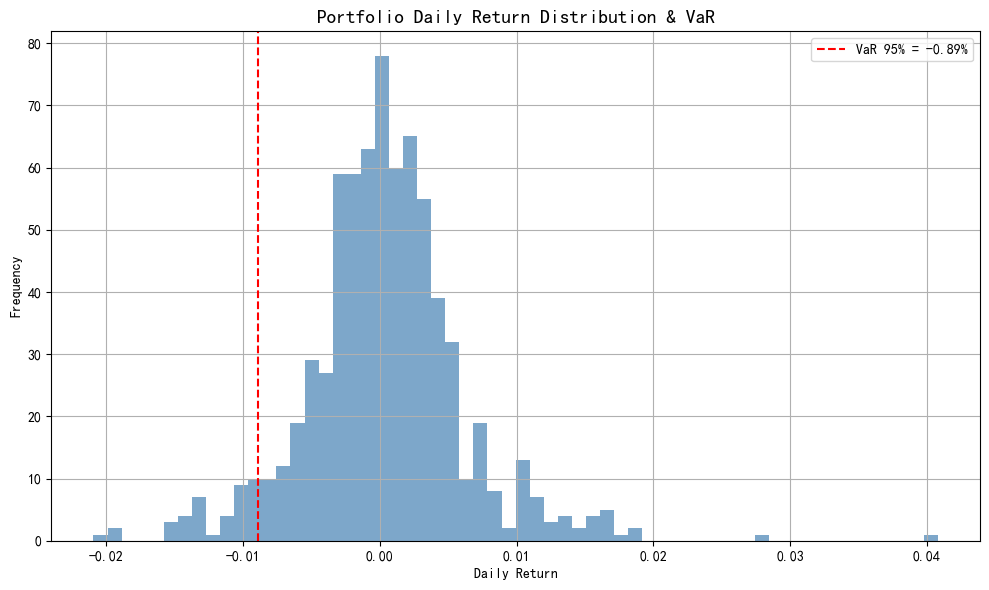

In [75]:
plt.figure(figsize=(10,6))
plt.hist(portfolio_ret, bins=60, color='steelblue', alpha=0.7)
plt.axvline(var_95, color='red', linestyle='--', label=f'VaR 95% = {var_95:.2%}')
plt.title('Portfolio Daily Return Distribution & VaR', fontsize=14)
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## ✅ CVaR（Conditional Value at Risk，条件在险价值）

CVaR 是对 VaR 的补充，关注在超过 VaR 的损失情况下的**平均损失**，可以更好地刻画极端风险情景下的潜在损失。


In [77]:
# 计算组合每日收益率
returns = prices.pct_change().dropna()

# 假设等权重组合
weights = np.array([1/len(tickers)] * len(tickers))
portfolio_returns = returns @ weights

# 计算 VaR 与 CVaR
confidence_level = 0.95
var = np.percentile(portfolio_returns, (1 - confidence_level) * 100)
cvar = portfolio_returns[portfolio_returns <= var].mean()

print(f"{int(confidence_level*100)}% VaR: {var:.4f}")
print(f"{int(confidence_level*100)}% CVaR: {cvar:.4f}")

95% VaR: -0.0089
95% CVaR: -0.0124



## ✅ VaR 贡献度分析（敏感性分析）

此模块用于分析各资产对组合总体 VaR 的边际贡献和总贡献（Component VaR），并可视化展示在热力图中，便于识别高风险来源。


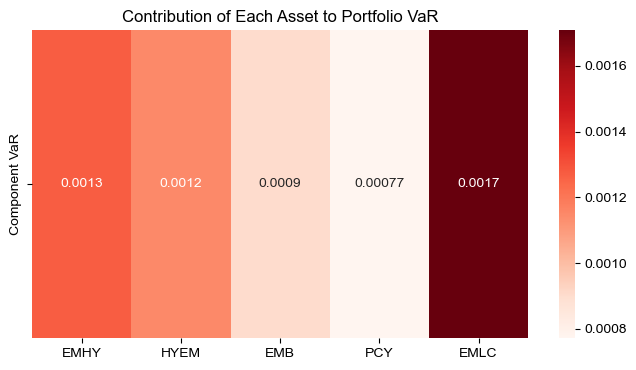

In [79]:
# 计算协方差矩阵 & 年化波动
cov_matrix = returns.cov()
portfolio_vol = np.sqrt(weights.T @ cov_matrix @ weights)

# 计算 Marginal VaR（边际 VaR）
marginal_var = cov_matrix @ weights / portfolio_vol

# 资产贡献度 (Component VaR)
component_var = weights * marginal_var

# 绘制热力图
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['font.family'] = 'Arial'

plt.figure(figsize=(8, 4))
sns.heatmap(
    component_var.values.reshape(1, -1),
    cmap="Reds",
    annot=True,
    xticklabels=tickers,
    yticklabels=["Component VaR"]
)
plt.title("Contribution of Each Asset to Portfolio VaR")
plt.show()


## ✅  Rolling VaR （60日窗口分析）


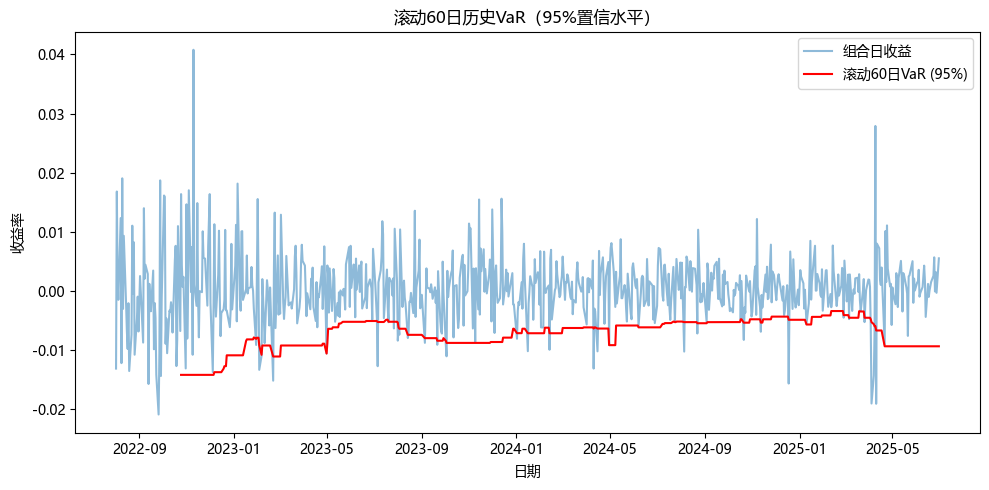

In [80]:
# --- 滚动VaR计算（历史模拟法，60日窗口）---
# 此模块展示组合风险如何随时间动态变化

import warnings
warnings.filterwarnings("ignore")  # 忽略可能的警告

import matplotlib
matplotlib.rcParams['font.family'] = 'Microsoft YaHei'
matplotlib.rcParams['axes.unicode_minus'] = False

rolling_window = 60  # 滚动窗口大小为60天
rolling_var_95 = portfolio_ret.rolling(window=rolling_window).quantile(0.05)  # 计算滚动VaR

# 绘图展示滚动VaR与实际组合收益
plt.figure(figsize=(10, 5))
plt.plot(portfolio_ret.index, portfolio_ret, label='组合日收益', alpha=0.5)
plt.plot(rolling_var_95, color='red', label=f'滚动{rolling_window}日VaR (95%)')
plt.title(f'滚动{rolling_window}日历史VaR（95%置信水平）')
plt.xlabel('日期')
plt.ylabel('收益率')
plt.legend()
plt.tight_layout()
plt.show()


## ✅ 压力冲击模拟


In [81]:
# 模拟三种宏观冲击下的投资组合表现（收益率下调）

scenarios = {
    "温和经济放缓": -0.015,
    "金融市场恐慌": -0.03,
    "新兴市场危机": -0.05
}

print("模拟压力场景下的VaR估算：")
for name, shock in scenarios.items():
    shocked_returns = portfolio_ret + shock
    shocked_var = np.percentile(shocked_returns, 5)
    shocked_dollar_var = shocked_var * portfolio_value
    print(f"{name}: VaR = {shocked_var:.2%}, 损失金额 = ${shocked_dollar_var:,.0f}")

模拟压力场景下的VaR估算：
温和经济放缓: VaR = -2.39%, 损失金额 = $-239,226
金融市场恐慌: VaR = -3.89%, 损失金额 = $-389,226
新兴市场危机: VaR = -5.89%, 损失金额 = $-589,226


## ✅VaR的蒙特卡洛模拟

Monte Carlo 模拟的 1-day VaR (95%): -1.6138%
对应 1000 万美元组合的名义 VaR 是: $-161,375


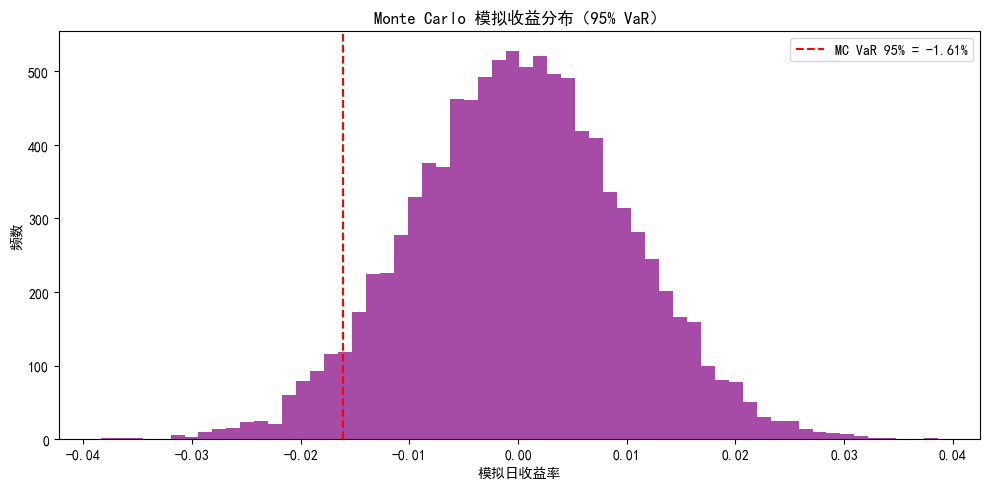

In [83]:
# 导入库
import numpy as np
import matplotlib.pyplot as plt

# 设置中文显示（避免图中中文乱码）
plt.rcParams['font.family'] = 'SimHei'  # 中文字体
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

portfolio_ret = np.random.normal(0.0005, 0.01, size=756)  # 模拟收益率序列

# 假设组合市值为1000万美元（用于换算为名义VaR）
portfolio_value = 10_000_000

# --- Monte Carlo Simulation for VaR ---
# 使用正态分布模拟未来价格路径，计算 VaR

np.random.seed(42)  # 设置随机种子，保证结果可复现
simulations = 10000  # 模拟次数

# 计算组合的平均收益率与标准差
mean_ret = portfolio_ret.mean()
std_ret = portfolio_ret.std()

# 模拟未来收益（正态分布）
simulated_returns = np.random.normal(loc=mean_ret, scale=std_ret, size=simulations)

# 获取5%分位点作为VaR
monte_carlo_var_95 = np.percentile(simulated_returns, 5)

# 换算成名义VaR金额
dollar_mc_var = portfolio_value * monte_carlo_var_95

# 打印结果
print(f"Monte Carlo 模拟的 1-day VaR (95%): {monte_carlo_var_95:.4%}")
print(f"对应 1000 万美元组合的名义 VaR 是: ${dollar_mc_var:,.0f}")

# 可视化：直方图展示模拟收益分布
plt.figure(figsize=(10, 5))
plt.hist(simulated_returns, bins=60, alpha=0.7, color='purple')
plt.axvline(monte_carlo_var_95, color='red', linestyle='--', label=f'MC VaR 95% = {monte_carlo_var_95:.2%}')
plt.title('Monte Carlo 模拟收益分布（95% VaR）')
plt.xlabel('模拟日收益率')
plt.ylabel('频数')
plt.legend()
plt.tight_layout()
plt.show()


## ✅投资组合优化：最小化VaR

In [85]:
from scipy.optimize import minimize
import numpy as np

# Step 1: 计算每日收益率矩阵
asset_returns = prices.pct_change().dropna()

# Step 2: 定义资产数量
num_assets = asset_returns.shape[1]

# Step 3: 定义 VaR 函数（负号是因为要最小化负的VaR）
def portfolio_var(weights, returns, alpha=0.05):
    port_ret = returns.dot(weights)
    return -np.percentile(port_ret, alpha * 100)

# Step 4: 初始等权权重
x0 = np.ones(num_assets) / num_assets

# Step 5: 权重边界和约束
bounds = [(0, 1) for _ in range(num_assets)]
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

# Step 6: 组合市值（比如1000万美元）
portfolio_value = 10_000_000

# Step 7: 执行优化
opt_result = minimize(portfolio_var, x0,
                      args=(asset_returns.values,),
                      method='SLSQP',
                      bounds=bounds,
                      constraints=constraints)

# Step 8: 输出结果
if opt_result.success:
    opt_weights = opt_result.x
    opt_var_95 = -portfolio_var(opt_weights, asset_returns.values)
    opt_dollar_var = opt_var_95 * portfolio_value

    print("✅ 最小VaR组合权重：")
    for name, w in zip(prices.columns, opt_weights):
        print(f"   {name}: {w:.3f}")

    print(f"\n组合 VaR (95%) 最小值：{opt_var_95:.4%}")
    print(f"对应 1000 万美元组合的名义 VaR：${opt_dollar_var:,.0f}")
else:
    print("❌ 优化失败：", opt_result.message)


✅ 最小VaR组合权重：
   EMB: 0.000
   EMHY: 0.221
   EMLC: 0.343
   HYEM: 0.437
   PCY: 0.000

组合 VaR (95%) 最小值：-0.6686%
对应 1000 万美元组合的名义 VaR：$-66,860
